# Neural Network Based Recommender System

Recommender Systems (RS) are information filtering algorithms aimed at providing users the most suitable items according to their historical consumption profile. They have been widely used in ecommerce platforms in order to suggest several types of utilities such as music tracks, movies or books. 


## Collaborative Filtering

In order to develop such systems, Collaborative Filtering (CF) has been widely applied to find like-minded users in a way that, if a target user is yet to consume a given item but his peers have done so, we could use his peer's evaluation to estimate how likely is the target user to consume the available items. 

Take the following image as an example:

<img src="./Results/Graphics/collaborative_filtering.png" title="Collaborative Filtering" width="400"/> 

If users *A*, *B* and *C* are like-minded users where A and B have positively rated the item "Breaking Bad", we could argue that *C* might also input a high rating for this item. 

Several methods have been presented in the literature in order to implement CF. For instance, neighborhood methods usually apply clustering algorithms in order to group users according to a similarity metric, such as the pearson's correlation coefficient. However, latent factors models have shown to be more effective and thus they will be applied in this notebook in order to make recommendations. 

## Latent Factors Models

Given a utility matrix $R_{n\times m}$, where $n$ and $m$ are the number of users and items, respectively, such matrix stores a rating relationship $r_{ui}$ between users and items. If a user $u$ rated and item $i$, then $r_{ui} \neq 0$. 

Therefore, the goal of most popular RS techniques is to fill in the missing gaps in the matrix, which would represent a prediction of the user's rating for all unseen items. In order to do so, latent factor models try to map both users and items to a latent factor space where they can be compared and, as a result, we can estimate which items are more closely related to a target user.

Take the following picture as an example of movie recommendation:

<img src="./Results/Graphics/latent_factors.png" title="Collaborative Filtering" width=500/> 

We could spot two latent factors axis which could indicate how much animation/action does a movie have or how geared towards children/adults they are. Hence, extracting the latent factors from the utility matrix is a useful tool to provide estimations of ratings. 

Classical latent factors extractions on RS are done using matrix factorization with Singular Value Decompostion of Non-negative Matrix Factorization. However, a neural network approach has been developed in the past years with the development of autoencoders. 

## Autoencoders 

Neural networks are biologically-inspired models that aim at learning data patterns through an artificial perceptron model. The following image depicts its representation.

<img src="./Results/Graphics/perceptron.png" title="Perceptron" width="600"/> 

The model is composed by 3 basic elements: the sinapsis, represented by the $w_i$ weights which multiply the input elements $x_i$ from the entry vector, a summerizer that aggregates the results from the multiplication together with a bias $b$ constant, and an activation function $\delta$ which generates an output $\hat{y}$. 

By cascating multiple perceptrons and forcing the output layer to be equal to the input layer, an autoencoder is constructed such as in the following picture.

<img src="./Results/Graphics/autoencoder.jpg" title="Collaborative Filtering" width=150/> 

We can observe that such structure creates an encoder and a decoder step that makes the hidden layer contain high-level representations of the input data. In the context of RS, the hidden layers contain latent factors from the utility matrix, proposing a neural network-based alternative to mapping users and items to a latent factor space where they can be compared. 

To demonstrate the use of neural networks on RS, this notebook implements an autoencoder and applies it to the MovieLens 1M dataset, which contains ratings from users to movies collected by the <a href="https://grouplens.org/">GroupLens</a> project.


# Implementation

## Imports

In [42]:
if './Sources' not in sys.path:
    sys.path.append('./Sources')

import os, sys
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from recommender.neural_networks import AE
from sklearn.model_selection import KFold, train_test_split
from sklearn.externals import joblib
import time

## Loading the Dataset

In [3]:
df_ratings = pd.read_csv('./Dataset/ratings.dat', sep='::', engine='python',header=None)
df_ratings.columns = ['user_id', 'item_id', 'feedback', 'timestamp']
df_ratings.head()

,user_id,item_id,feedback,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## Preprocessing
In terms of preprocessing, the MovieLens 1M is well defined in the sense of data quality. From its $1000209$ registers, none of them has null entries and no outlier is detected in terms of ratings. In fact, all ratings are discrete values ranging from 1 to 5 as it should be. Therefore, no preprocessing in terms of outliers or missing values are applied for this analysis. 

However, since the data ranges 1 to 5 and our model is a perceptron-based neural network, scaling and normalization need to be adressed when inputing the utility matrix in the model, for ideally our data should:
- ranged [-1,1]
- have zero mean
- have unit variance

Scaling and normalization methods are applied in the AE class, which is discussed later.

In [4]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
user_id      1000209 non-null int64
item_id      1000209 non-null int64
feedback     1000209 non-null int64
timestamp    1000209 non-null int64
dtypes: int64(4)
memory usage: 30.5 MB


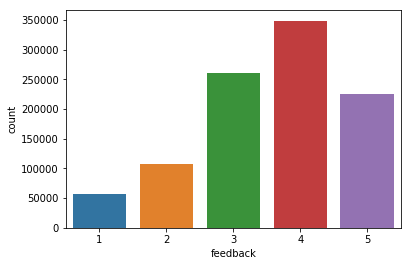

In [45]:
sns.countplot(x='feedback', data=df_ratings)

After pivotting our dataset into a fulfilled utility matrix, we get the following cenario.

In [29]:
df_utility_matrix = df_ratings.pivot(index='user_id', columns='item_id', values='feedback').fillna(0)
df_utility_matrix.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0,0.5,'Items')

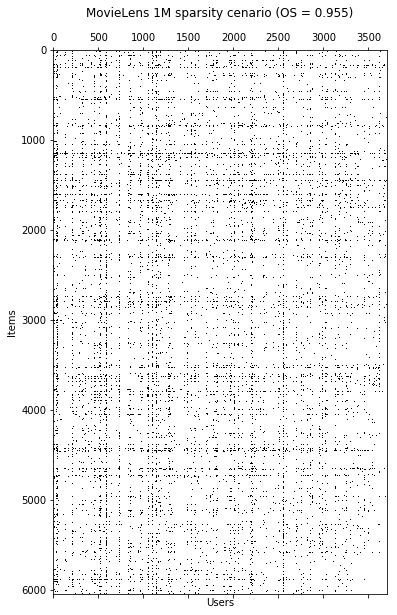

In [40]:
os = 1-np.count_nonzero(df_utility_matrix.as_matrix())/(df_utility_matrix.shape[0]*df_utility_matrix.shape[1])

fix, ax = plt.subplots(1, 1, figsize=(10,10))
ax.spy(df_ratings.pivot(index='user_id', columns='item_id', values='feedback').fillna(0).as_matrix())
ax.set_title('MovieLens 1M sparsity cenario (OS = {:.03f})'.format(os))
ax.set_xlabel('Users')
ax.set_ylabel('Items')

The Overall Sparsity (OS) is defined as $OS = 1 - \frac{\#non-zero-elements}{\#elements}$, where $OS \rightarrow 1$ means we have little or no information and, oppositely, $OS \rightarrow 0$ means we have a densely filled utility matrix. As we can see in the results above, the MovieLens 1M dataset yields a rather sparse utility matrix, having an OS of $95.5\%$. 


## Autoencoder Recommender Class

For the purpose of having a cleaner notebook, the autoencoder recommender class (AE) is defined in the `Sources/recommender/autoencoder.py` file. Its initialization parameters are presented as follows:

```python
AE(train_set=None, test_set=None, random_seed=None, 
   num_neurons=10, epochs = 2000, learning_rate=0.001, 
   loss_metric='mse', training_metrics=['mae'], patience=10, 
   kernel_initializer='random_uniform')
```
| Argument | Description | 
| -------- | ----------- |
| train_set | the training data to me used. |
| test_set | if not passed, training_set will be the only one evaluated |
| random_seed | a integer number for experiment's reproducibility |
| num_neurons | the number of neurons in the autoencoder's hidden layer |
| epochs | maximum number of training epochs |
| learning_rate | initial learning rate for the keras' Adam optimizer |
| loss_metric | an evaluation metric to be minimized in training |
| training_metrics | metrics for evaluation purposes only (should not be minimized during training) |
| patience | number of epochs for early stopping |
| kernel_initializer | method to initialize neural network's weghts |

Here is a brief example of how to use the AE class

In [5]:
df_train, df_test = train_test_split(df_ratings, test_size=0.2)

In [6]:
%%time
model = AE(df_train, df_test, num_neurons=10)
model.fit()

The activation functions used in the model were the SELU (scaled exponential linear unit) and TANH (hiperbolic tangent) for the hidden and output layer, respectively. The choice of these activation functions were based on the results presented in the paper <a href="https://arxiv.org/abs/1708.01715">*"Training Deep Autoencoders for Collaborative Filtering" (2017)*</a>, by Oleksii Kuchaiev and Boris Ginsburg where the effects of activation types are shown. 

Since neural networks are mostly based on stochastic optimization algorithms, which uses randomness in order to find minimal values of a loss function, the network needs its weights to be randomly initialize according to a distribution function. Heuristics-wise, this analysis uses the random uniform function as a default kernel initializer, but other distributions can be applied. An article for a deeper understanding on why parameters initialization should be made can be found <a href "https://machinelearningmastery.com/why-initialize-a-neural-network-with-random-weights/">here</a>. 

In views of cost functions, the one to be used in the model's training was the Mean Squared Error (MSE). The choice of such function was based on its characteric of penalizing more severely greater error when compared to the Mean Absolute Error (MAE). 

In terms of RS, a slightly modified variation of MAE and Root Mean Squared Error (RMSE) are used to evaluate recommendation quality. Instead of simply comparing the input matrix with its output counterpart, we should not take into account on evaluations the zero-entries in the input matrix. 

These zero-entries are representations of missing values and they do not express the users' consumption preferences. In other words, having a zero-entry does not mean the user has given a zero rating to an item. As a result, we should not consider the zero-entries when comparing the input and output matrices and that is why the AE class has the following evaluation function:
```python
get_loss(test_matrix=False)
```

The `test_matrix` argument specifies if we want to take into account only the test_set (if it was passed in the object's initialization parameters). 

In [8]:
model.get_loss()

{'mae': 2.685107642343558, 'rmse': 2.946230864144297}

In [46]:
model.get_loss(test_matrix=True)

{'mae': 2.350589387210715, 'rmse': 2.6818356742001903}

## Hyperparameter sweep
In order to find an appropriate number of neurons in the hidden layer, an hyperparameter sweep is applied as follows.

In [47]:
def insert_row(df, arr):  
    # auxiliary function to append rows in a panda's dataframe
    df.loc[-1] = arr  # adding a row
    df.index = df.index + 1  # shifting index
    df = df.sort_index() 
    return df

In [48]:
%%time
arr_neurons = np.arange(100, 1050, 50) #[100, 200, 400, 800, 1600]
df_results = pd.DataFrame(columns=['neurons', 'mae', 'mse', 'mae_val', 'mse_val', 'time'])
arr_results = []

df_train, df_test = train_test_split(df_ratings, test_size=0.2)

for num_neurons in arr_neurons:
    start_time = time.time()
    arr_results = []
    arr_results.append(num_neurons)
    
    model = AE(df_train, df_test, num_neurons=num_neurons)
    model.fit()    
    
    loss = model.get_loss()    
    arr_results.append(loss['mae'])     
    arr_results.append(loss['rmse'])     
    
    loss_val = model.get_loss(test_matrix=True)        
    arr_results.append(loss_val['mae'])     
    arr_results.append(loss_val['rmse'])     
    
    arr_results.append(time.time() - start_time)    
    
    df_results = insert_row(df_results, arr_results)    
    joblib.dump(df_results, './Results/Variables/df_results.joblib')
    
    print ("Elapsed time for " + str(num_neurons) + " neurons: " + str(time.time() - start_time))


Elapsed time for 100 neurons: 226.5495982170105
Elapsed time for 150 neurons: 377.1225447654724
Elapsed time for 200 neurons: 646.6672143936157
Elapsed time for 250 neurons: 781.4624409675598
Elapsed time for 300 neurons: 874.969710111618
Elapsed time for 350 neurons: 1072.1814079284668
Elapsed time for 400 neurons: 910.2256150245667
Elapsed time for 450 neurons: 176.04623818397522
Elapsed time for 500 neurons: 151.1623558998108
Elapsed time for 550 neurons: 175.27391028404236
Elapsed time for 600 neurons: 162.85296082496643
Elapsed time for 650 neurons: 162.75217723846436
Elapsed time for 700 neurons: 184.78831553459167
Elapsed time for 750 neurons: 181.40198707580566
Elapsed time for 800 neurons: 190.56769824028015
Elapsed time for 850 neurons: 203.12507271766663
Elapsed time for 900 neurons: 212.3204939365387
Elapsed time for 950 neurons: 225.41125082969666
Elapsed time for 1000 neurons: 236.0881383419037
Wall time: 1h 59min 11s


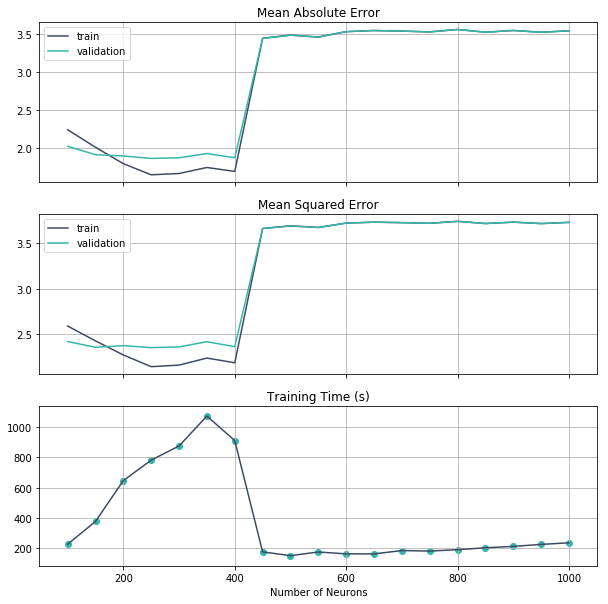

In [56]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10,10))
ax[0].plot(df_results['neurons'], df_results['mae'], label='train', color='#3e4a64')
ax[0].plot(df_results['neurons'], df_results['mae_val'], label='validation', color='#34b6ab')
ax[0].set_title('Mean Absolute Error')
ax[0].legend()
ax[0].grid()

ax[1].plot(df_results['neurons'], df_results['mse'], label='train', color='#3e4a64')
ax[1].plot(df_results['neurons'], df_results['mse_val'], label='validation', color='#34b6ab')
ax[1].set_title('Mean Squared Error')
ax[1].legend()
ax[1].grid()

ax[2].plot(df_results['neurons'], df_results['time'], color='#3e4a64')
ax[2].scatter(df_results['neurons'], df_results['time'], color='#34b6ab')
ax[2].set_title('Training Time (s)')
ax[2].grid()
ax[2].set_xlabel('Number of Neurons')

fig.savefig('./Results/Graphics/neurons_sweep_autoencoder.jpeg', bbox_inches='tight')

After sweeping the number of neurons in the hidden layer from $100$ to $1000$ with a step of 50, an autoencoder having $~400$ neurons in its hidden layer should have the lowest performance metrics for the MovieLens 1M dataset. 

In [54]:
n_hidden_neurons = 400

## Evaluation

In [57]:
%%time
n_folds = 5
kf = KFold(n_splits=n_folds)
dict_results = {'epochs': [], 'loss': [], 'val_loss': [], 'mae': [], 'val_mae': []}
best_metric = 99
best_model = None

for train_index, test_index in kf.split(df_ratings):
    print (df_ratings.iloc[train_index].shape, df_ratings.iloc[test_index].shape)
    df_train, df_test = df_ratings.iloc[train_index], df_ratings.iloc[test_index]

    model = AE(df_train, df_test, num_neurons=n_hidden_neurons, training_metrics=['mae', 'mse'])
    model.fit() 
    
    dict_results['epochs'].append(model.fit_history.epoch)
    dict_results['loss'].append(model.fit_history.history['loss'])
    dict_results['val_loss'].append(model.fit_history.history['val_loss'])
    dict_results['mae'].append(model.fit_history.history['mean_absolute_error'])
    dict_results['val_mae'].append(model.fit_history.history['val_mean_absolute_error'])
    
    # Saving current best model
    if model.get_loss(test_matrix=True)['rmse'] < best_metric:
        best_model = model
        best_model.save('./Results/Variables/best_autoencoder_model.hdf5')
    

(800167, 4) (200042, 4)
(800167, 4) (200042, 4)
(800167, 4) (200042, 4)
(800167, 4) (200042, 4)
(800168, 4) (200041, 4)
Wall time: 1h 16min 38s


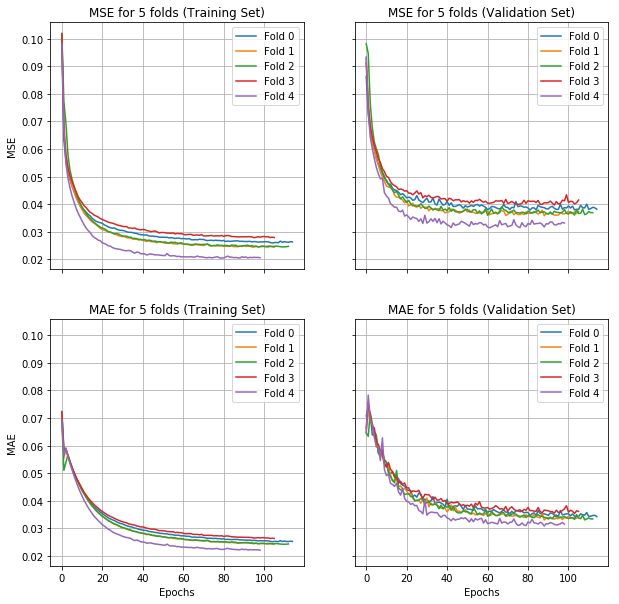

In [98]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,10))

for index in np.arange(n_folds):
    ax[0][0].plot(dict_results['epochs'][index], dict_results['loss'][index], label='Fold ' + str(index))
    ax[0][1].plot(dict_results['epochs'][index], dict_results['val_loss'][index], label='Fold ' + str(index))
    ax[1][0].plot(dict_results['epochs'][index], dict_results['mae'][index], label='Fold ' + str(index))
    ax[1][1].plot(dict_results['epochs'][index], dict_results['val_mae'][index], label='Fold ' + str(index))
    
ax[0][0].set_title('MSE for ' + str(n_folds) + ' folds (Training Set)')
ax[0][0].legend()
ax[0][0].grid()
ax[0][0].set_ylabel('MSE')
ax[0][1].set_title('MSE for ' + str(n_folds) + ' folds (Validation Set)')
ax[0][1].legend()
ax[0][1].grid()
ax[1][0].set_title('MAE for ' + str(n_folds) + ' folds (Training Set)')
ax[1][0].legend()
ax[1][0].grid()
ax[1][0].set_xlabel('Epochs')
ax[1][0].set_ylabel('MAE')
ax[1][1].set_title('MAE for ' + str(n_folds) + ' folds (Validation Set)')
ax[1][1].legend()
ax[1][1].grid()
ax[1][1].set_xlabel('Epochs')

fig.savefig('./Results/Graphics/cross_validation_results.jpeg', bbox_inches='tight')

The analysis above shows that in all folders, no overfitting is presented to 200 epochs. Also, all test set evaluations have presented a slighly higher error but not sufficient to discard the model's training. 

As aforementioned, RS have a slightly different way of analyzing RMSE and MAE. All zero-entries are masked since they do not represent the out true target. In fact, the purpose of a RS is precisely make the reconstruction matrix to have different values from the ones in the input matrix. Otherwise, we are just reconstructing the already known ratings. 

Consequently, here follows the modified evaluation for the MAE and RMSE applied to the validation set for the best model in the cross-validation analysis. 

In [100]:
print ('Recommendation metrics (val set): ', best_model.get_loss(test_matrix=True))

Recommendation metrics (val set):  {'mae': 1.512051588599118, 'rmse': 1.9784955719056696}


## Making Recommendations

To finally demonstrate recommentations, we present the `get_user_prediction` and `get_user_top_n` methods of the AE class. 

The first method takes as input the id of the user and the item which we want to discover the predicted rating. If any of these IDs are not set in the training, an error is shown. 

The later method, on the other hand, takes as input the id of a user and a number $n$ of items to be predicted. The method returns the top $N$ items that the user has not consumed and brings them to suggestion. 

In [111]:
user_id = 10
item_id = 7
print ('User ID {} would rate {:.02f} for item ID {}'.format(user_id, best_model.get_user_prediction(user_id=user_id, item_id=item_id), item_id))

User ID 10 would rate 5.00 for item ID 7


In [112]:
top_n = 10
print ("Top {} movies for user ID {}: ".format(top_n, user_id), best_model.get_user_top_n(user_id, top_n))

Top 10 movies for user ID 10:  [3952 3951 3950 3949 3947 3946 3945 3944 3943 3942]


## Conclusion

The implementation and results shown above illustrates how autoencoders can be applied to predict users' preferences in a rating-based RS. The model is a non-linear alternative to classical matrix factorization approaches presented in the literature and it can access high order statistics which grants this approach robustness to more complex data. However, a few limitations can be listed to the presented model. 

Firstly, since the autoencoder's core data is the utility matrix, no time-related input is taken into account in the model. This is a major setback to classical matrix factorization models due to the fact that they estimate long-term consumption profiles instead of short-term ones. This yields to the so called cold-start problem, where a RS takes too long to make high quality recommendations to new users. Since the system does not have any information on new users, their latent factors would be poorly representative and thus the quality of recommendations would be affected. 

Another neural network-based alternative to RS which have been implemented in the past few years is the application of Long-Short Term Memory (LSTM), as presented by <a href = "http://iridia.ulb.ac.be/~rdevooght/papers/UMAP__Long_and_short_term_with_RNN.pdf">Robin Devooght and Hughes Bersini</a>. 

Further on the use of utility matrix drawbacks as a core data source is the availability of ratings. Ratings are considered to be explicit feedback in the sense that they are purposely input by users. However, in many real world cenarios users do not take time to evaluate items and, more importantly, users may not be well identified. 

Many e-commerce platforms need to deal with anonymous users in a way that every user is a new user, which would greately enhance the cold-start problem. Therefore, using implicit feedback such as page viewing time, browsing history or page clicks are needed in order to overcome this issue, but it also brings the necessity of more complex data representations of users.

In conclusion, autoencoders can be quite useful to overcome classical implementations of RS that are based on the utility matrix. They come as a non-linear alternative to finding long-term consumption profiles but they also have the limitation of not dealing with short-term predictions. In order to do so, time-based variables need to be taken into consideration in order to make better predictions and, thus, improving the user's experience with a personalized service. 